In [389]:
%reload_ext autoreload

In [390]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
from quantum_tools.examples import symbolic_contexts
from quantum_tools.symmetries.workspace import get_contraction_elements
from quantum_tools.config import *
from quantum_tools.visualization.sparse_vis import plot_matrix
from scipy import sparse
import numpy as np
from scipy import io
import os
from functools import reduce
from operator import mul
from quantum_tools.hypergraph.hypergraph_transversals import *

In [3]:
symbolic_contexts.ABC_444_444.preinjectable_sets
# symbolic_contexts.ABC_444_444.outcomes

[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']],
 [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']],
 [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']],
 [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']],
 [['A1'], ['B3'], ['C4']],
 [['A1'], ['B4'], ['C2']],
 [['A2'], ['B1'], ['C4']],
 [['A2'], ['B2'], ['C2']],
 [['A3'], ['B3'], ['C3']],
 [['A3'], ['B4'], ['C1']],
 [['A4'], ['B1'], ['C3']],
 [['A4'], ['B2'], ['C1']]]

In [4]:
small_row_sum, small_A, small_col_sum, small_contracted_A = get_contraction_elements(symbolic_contexts.ABC_222_222)

40 64
ShiftedBase(shift=0, base=(32, 16, 8, 4, 2, 1))
ShiftedBase(shift=0, base=(0, 4, 0, 2, 0, 1))
ShiftedBase(shift=8, base=(0, 4, 0, 2, 1, 0))
ShiftedBase(shift=16, base=(4, 0, 0, 2, 0, 1))
ShiftedBase(shift=24, base=(0, 4, 2, 0, 0, 1))
ShiftedBase(shift=32, base=(4, 0, 2, 0, 1, 0))
Found 14 row_orbits.
Found 20 col_orbits.


In [5]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(symbolic_contexts.ABC_444_444)

16896 16777216
ShiftedBase(shift=0, base=(4194304, 1048576, 262144, 65536, 16384, 4096, 1024, 256, 64, 16, 4, 1))
ShiftedBase(shift=0, base=(1024, 0, 0, 256, 64, 0, 0, 16, 4, 0, 0, 1))
ShiftedBase(shift=4096, base=(1024, 0, 0, 256, 0, 64, 16, 0, 0, 4, 1, 0))
ShiftedBase(shift=8192, base=(0, 1024, 256, 0, 0, 64, 16, 0, 4, 0, 0, 1))
ShiftedBase(shift=12288, base=(0, 1024, 256, 0, 64, 0, 0, 16, 0, 4, 1, 0))
ShiftedBase(shift=16384, base=(16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1))
ShiftedBase(shift=16448, base=(16, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0))
ShiftedBase(shift=16512, base=(0, 16, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1))
ShiftedBase(shift=16576, base=(0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0))
ShiftedBase(shift=16640, base=(0, 0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0))
ShiftedBase(shift=16704, base=(0, 0, 16, 0, 0, 0, 0, 4, 1, 0, 0, 0))
ShiftedBase(shift=16768, base=(0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 1, 0))
ShiftedBase(shift=16832, base=(0, 0, 0, 16, 0, 4, 0, 0, 1, 0, 0, 0))
Found 450 row_orbits.
Found 358120 col_o

In [6]:
contracted_A

<450x358120 sparse matrix of type '<class 'numpy.int32'>'
	with 3566922 stored elements in Compressed Sparse Row format>

# Optimization Pipeline

1. Params ✓
1. Measurement Operators, States ✓
1. QuantumContext ✓
1. Probability Distribution ✓
1. Marginal Factorized Context Vector ✓
1. Row Sum Contraction ✓
1. Hypergraph Selection Contraction ✓
1. Antecedent, Consequent Selection ✓
1. Inequality Evaluation ✓

## Set up global variables for optimization

In [427]:
USE_ORBITS = False
antecedent = 30
preinjectable_sets = symbolic_contexts.ABC_444_444.preinjectable_sets
dimensions = 3
triangle_permutation = utils.get_triangle_permutation(dimensions)
if USE_ORBITS:
    hg_rows, hg_cols = hyper_graph_contraction(contracted_A, antecedent, remove_ant=True)
    hg = hyper_graph(contracted_A, antecedent)    
    orbit_contractor = row_sum
else:
    hg_rows, hg_cols = hyper_graph_contraction(A, antecedent, remove_ant=True)
    hg = hyper_graph(A, antecedent)    
    orbit_contractor = None

## Comments on Dimensions

If $d$ is the dimension, a single state is a $d$-vector, making a two party state $d^2$ vector.

With three states, thats a joint state of $(d^2)^3 = d^6$ size.

For $d=2$, thats a $2^6 = 64$ by $64$ matrix with $d^{12} = 4096$ entries.

| $d$ | $d^{12}$   |
|------|------|
|1|1|
|2|4096|
|3|531441|
|4|16777216|


In [445]:
triangle_permutation.shape

(729, 729)

## Plots the hypergraph that is currently being tested against

<IPython.core.display.Javascript object>


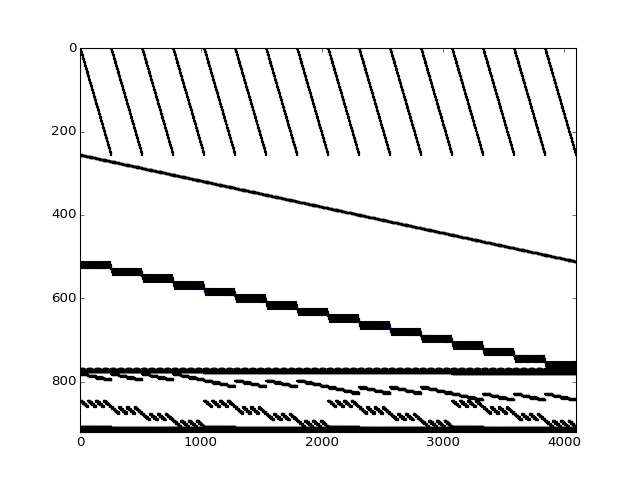

In [430]:
plot_matrix(hg)

In [352]:
"""
Converts from a probability distribution to a target for a particular inequality
"""
def get_b(pd):
    b = marginal_equality.contexts_marginals(pd, preinjectable_sets) # The marginals over the preinjectable sets
    if USE_ORBITS:
        return orbit_contractor.dot(b) # The new contracted marginals into orbits
    else:
        return b

def pd_to_ineq_target(pd, transversal):
    """
    pd: The Probability Distribution in question
    transversal: The indices or selector to get the consequent
    """
    b = get_b(pd)
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # Same reduction made to get transveral
    
    consequent_values = marginals_hg_space[transversal] # The values of the particular consequents
    target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
    return target

def pd_to_many_ineq_target(pd, transversals):
    """
    pd: The Probability Distribution in question
    transversals: The fts array
    """
    b = get_b(pd)
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # Same reduction made to get transveral

    num_targets = transversals.shape[1]
    targets = np.zeros(num_targets)
    for i in range(num_targets):
        indices = transversals[:, i].indices
        consequent_values = marginals_hg_space[indices] # The values of the particular consequents
        target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
        targets[i] = target
    return targets

## Testing against particular distributions

In [434]:
from quantum_tools.examples.prob_dists import *
from quantum_tools.contexts.quantum_context import QuantumContext, QuantumProbDist, QuantumProbDistOptimized
from quantum_tools.contexts.measurement import Measurement

rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))
fritz_dist = fritz(rvc)
spekkens_dist = spekkens(rvc)

def uniform_sample_qdistro(rvc):
    if dimensions**2 == 4:
        A = Measurement.Strats.Random.pvms_uniform(4)
        B = Measurement.Strats.Random.pvms_uniform(4)
        C = Measurement.Strats.Random.pvms_uniform(4)
    else:
        A = Measurement.Strats.Random.pvms_outcomes(4, dimensions**2)
        B = Measurement.Strats.Random.pvms_outcomes(4, dimensions**2)
        C = Measurement.Strats.Random.pvms_outcomes(4, dimensions**2)
    rhoAB = State.Strats.Random.pure_uniform(dimensions**2)
    rhoBC = State.Strats.Random.pure_uniform(dimensions**2)
    rhoAC = State.Strats.Random.pure_uniform(dimensions**2)
        
    qc = QuantumContext(random_variables=rvc, measurements=(A,B,C), states=(rhoAB, rhoBC, rhoAC), permutation=triangle_permutation)
    pd = QuantumProbDist(qc)
    return pd, qc

rpd, rqc = uniform_sample_qdistro(rvc)
print(rpd)

=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
36 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 0.04123613436093785
[0, 0, 2] -> 0.06698808436943551
[0, 0, 3] -> 0.07935914588373233
[0, 1, 0] -> 0.0172430542096873
[0, 1, 2] -> 0.04841264385281593
[0, 1, 3] -> 0.06523361612407244
[0, 2, 0] -> 0.017164960643548426
[0, 2, 2] -> 0.014403077672076305
[0, 2, 3] -> 0.03497470647874415
[0, 3, 0] -> 0.029530366097082532
[0, 3, 2] -> 0.08125805366709267
[0, 3, 3] -> 0.06635371981832033
[1, 0, 0] -> 0.031790220100675115
[1, 0, 2] -> 0.05816550491975819
[1, 0, 3] -> 0.055473104076862914
[1, 1, 0] -> 0.01463034818240354
[1, 1, 2] -> 0.03714212535515725
[1, 1, 3] -> 0.04678511337853068
[1, 2, 0] -> 0.010287598372196269
[1, 2, 2] -> 0.012490413990778866
[1, 2, 3] -> 0.023003823024920933
[1, 3, 0] -> 0.015311963845557752
[1, 3, 2] -> 0.0426464223441968
[1, 3, 3] -> 0.03832498540456941
[3, 0, 0] -> 0.

In [457]:
def test():
    pd, qc = uniform_sample_qdistro(rvc)
    targets = pd_to_many_ineq_target(pd, fts)
    print(np.where(targets<0))
    return pd, qc

pd, qc = test()

(array([], dtype=int64),)


<IPython.core.display.Javascript object>


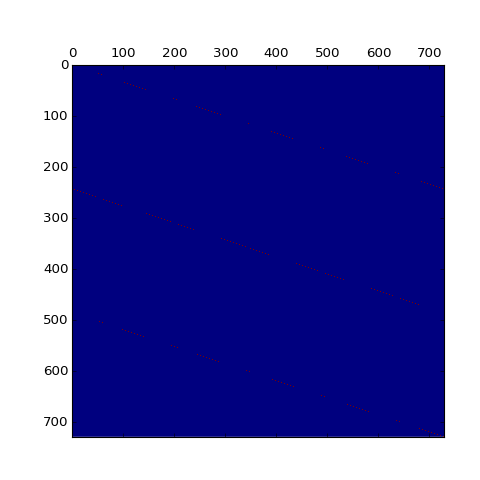

In [426]:
plt.matshow(np.real(utils.get_triangle_permutation(3)), interpolation='none')

In [396]:
Measurement.Strats.Random.__dict__

mappingproxy({'__doc__': None, '__module__': 'quantum_tools.contexts.measurement', 'pvms_uniform': <staticmethod object at 0x7fae37c0d940>, 'seesaw': <staticmethod object at 0x7fae37c0d9e8>, 'proj_comp': <staticmethod object at 0x7fae37c0d9b0>, '__weakref__': <attribute '__weakref__' of 'MeasurementStratsRandom' objects>, '__dict__': <attribute '__dict__' of 'MeasurementStratsRandom' objects>})

In [361]:
def random_sample_test(num, fts):
    for i in range(num):
        pd, qc = uniform_sample_qdistro(rvc)
        targets = pd_to_many_ineq_target(pd, fts)
#         print(targets)
        if np.any(targets < 0):
#             print(targets[np.where(targets < 0)])
            print(qc)
            break
            
def test_indef(fts):
    tests = 0
    diff = 25000
    while True:
        pd, qc = uniform_sample_qdistro(rvc)
        targets = pd_to_many_ineq_target(pd, fts)
        if np.any(targets < 0):
            print(qc)
            return qc
        pre_tests = tests
        tests += len(targets)
        if tests // diff != pre_tests // diff:
            print(tests)

In [364]:
qc = test_indef(fts)

25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000
450000
475000
500000
525000
550000
575000
600000
625000
650000
675000
700000
725000
750000
775000
800000
825000
850000
875000
900000
925000
950000
975000
1000000
1025000
1050000
1075000
1100000
1125000
1150000
1175000
1200000
1225000
1250000
1275000
1300000
1325000
1350000
1375000
1400000
1425000
1450000
1475000
1500000
1525000
1550000
1575000
1600000
1625000
1650000
1675000
1700000
1725000
1750000
1775000
1800000
1825000
1850000
1875000
1900000
1925000
1950000
1975000
2000000
2025000
2050000
2075000
2100000
2125000
2150000
2175000
2200000
2225000
2250000
2275000
2300000
2325000
2350000
2375000
2400000
2425000
2450000
2475000
2500000
2525000
2550000
2575000
2600000
2625000
2650000
2675000
2700000
2725000
2750000
2775000
2800000
2825000
2850000
2875000


KeyboardInterrupt: 

In [318]:
# PROFILE_MIXIN(random_sample_test, 100, fts)
print(pd_to_many_ineq_target(fritz_dist, fts))
print(pd_to_many_ineq_target(spekkens_dist, fts))
random_sample_test(10, fts)

[ 0.281  0.31   0.299 ...,  0.299  0.314  0.299]
[ 0.289  0.309  0.305 ...,  0.305  0.32   0.305]


## Compute Transversals

In [226]:
# ignore = np.array(hg.sum(axis=1) > 20000).flatten() 
# ignore[which_nodes_essential(hg)] = False

In [335]:
strat = TransversalStrat(
    search_type='depth',
    find_up_to=100,
    node_brancher={
#         'name': 'greedy',
#         'max': 5,
#         'ignore' : ignore,
        'shuffle' : True,
    }
)

fts = find_transversals(hg, strat=strat, log_wt=False, log_ft=False)

In [304]:
def which_nodes_essential(hg):
    hg = sparse.csc_matrix(hg, copy=True)
    hg.data.fill(1)
    where_edges = np.array(hg.sum(axis=0) == 1).flatten()
    reduced = hg[:, where_edges]
    return reduced.indices

In [283]:
which_nodes_essential(hg)

array([], dtype=int32)

In [339]:
# utils.save_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx', fts)
fts = utils.load_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx')
fts = sparse.csc_matrix(fts)
fts

<920x5000 sparse matrix of type '<class 'numpy.int32'>'
	with 151351 stored elements in Compressed Sparse Column format>

In [316]:
import matplotlib.pyplot as plt

def visualize_overlap(fts):
    plt.matshow((fts.T * fts).todense(), interpolation='none')
    
def dense_plot_matrix(fts):
    plt.matshow(fts.todense(), interpolation='none')

/usr/local/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


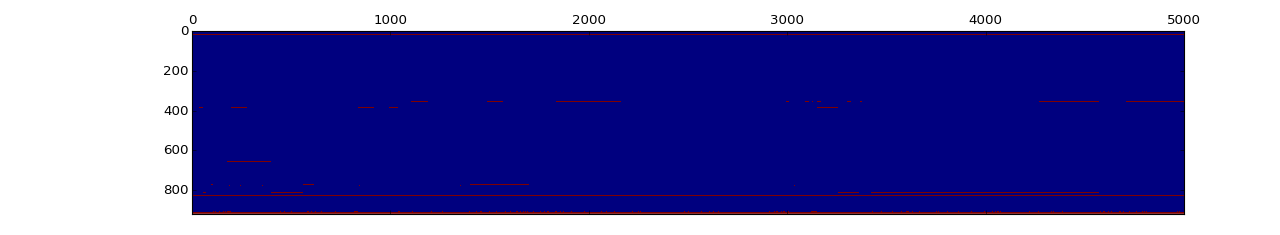

In [317]:
dense_plot_matrix(fts)

/usr/local/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


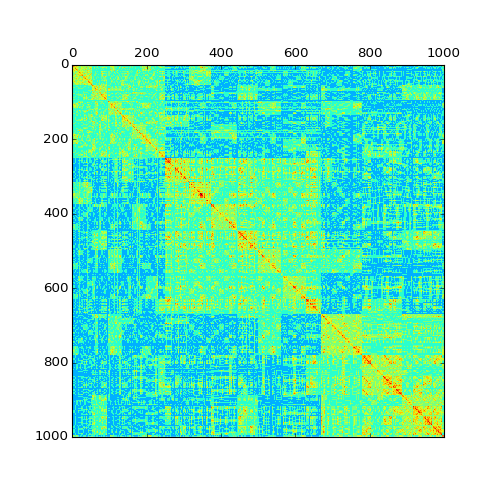

In [307]:
visualize_overlap(fts)

### Storing computed transversals (Evaluated Once)

In [49]:
fts_100_depth_ant_0 = fts
fts_100_depth_ant_0

<95x100 sparse matrix of type '<class 'numpy.int16'>'
	with 2209 stored elements in Compressed Sparse Column format>

In [80]:
fts_100_depth_ant_40 = fts
fts_100_depth_ant_40

<295x100 sparse matrix of type '<class 'numpy.int16'>'
	with 11182 stored elements in Compressed Sparse Column format>

In [111]:
fts_200_depth_ant_0 = fts
fts_200_depth_ant_0

<95x200 sparse matrix of type '<class 'numpy.int16'>'
	with 4489 stored elements in Compressed Sparse Column format>

## Pick a transversal to optimize against

In [355]:
fts

<920x5000 sparse matrix of type '<class 'numpy.int32'>'
	with 151351 stored elements in Compressed Sparse Column format>

In [356]:
hom_transversal = fts[:, min(19, fts.shape[1] - 1)].indices # pick a particular transversal to optimize against
# print(hom_transversal)
hom = HardyOrbitMinimizer(log=True)
hom.minimize()
# PROFILE_MIXIN(hom.minimize)
# hom.save_results_to_file(OUTPUT_DIR + "HOM_temp.txt")

'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264279'
'Calculated objective:, 0.361369264285'
'Calculated objective:, 0.361369264282'
'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264328'
'Calculated objective:, 0.36136926429'
'Calculated objective:, 0.361369264293'
'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264261'
'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264289'
'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264282'
'Calculated objective:, 0.361369264279'
'Calculated objective:, 0.361369264295'
'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264283'
'Calculated objective:, 0.361369264286'
'Calculated objective:, 0.361369264289'
'Calculated objective:, 0.361369264292'
'Calculated objective:, 0.361369264265'
'Calculated objective:, 0.361369264293'
'Calculated objective:, 0.361369264304'
'Calculated objective:, 0.361369264292'
'

In [397]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *
from quantum_tools.contexts.measurement import Measurement
from quantum_tools.contexts.state import State
from quantum_tools.statistics.variable import RandomVariableCollection
from quantum_tools.inflation import marginal_equality
from quantum_tools.examples import symbolic_contexts
from quantum_tools.contexts.quantum_context import QuantumContext, QuantumProbDist, QuantumProbDistOptimized

class HardyOrbitMinimizer(Minimizer):

    def __init__(self, log=False):
        Minimizer.__init__(self, [32,32,32,16,16,16])
        self.local_log = log
        self.permutation = triangle_permutation
        self.random_variables = rvc
        self.tolerance = 1e-3
        self.max_evals = 1
#         self.preinjectable_sets = 
#         self.orbit_contractor = row_sum
#         self.antecedent = antecedent
#         self.transversal_indicies = transversal_indicies # pick a particular transversal to optimize against
#         self.hg_rows = hg_rows

    def initial_guess(self):
        initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        return initial_guess

    def get_context(self, param):
        pA, pB, pC, prhoAB, prhoBC, prhoAC = self.mem_slots
        A = Measurement.Strats.Param.pvms(param[pA])
        B = Measurement.Strats.Param.pvms(param[pB])
        C = Measurement.Strats.Param.pvms(param[pC])
        rhoAB = State.Strats.Param.dm(param[prhoAB])
        rhoBC = State.Strats.Param.dm(param[prhoBC])
        rhoAC = State.Strats.Param.dm(param[prhoAC])

        qc = QuantumContext(
            random_variables=self.random_variables,
            measurements=(A,B,C),
            states=(rhoAB,rhoBC,rhoAC),
            permutation=self.permutation,
        )
        return qc

    def objective(self, param):
        qc = self.get_context(param)
        pd = QuantumProbDistOptimized(qc)

        target = pd_to_ineq_target(pd, hom_transversal)
        self.log("Calculated objective:", target)
        return target